# Introduction

This notebook demonstrates the model implementation for the Kuehn et al. (2024) fault displacement model using the accompanying Python package.

# Import libraries

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import kuehn_et_al_fdm as kea

In [2]:
# Ensure warnings show in the notebook
import warnings

warnings.filterwarnings(action='once')

# Help

In [3]:
# View the Quick Usage Guide
kea.help()

kuehn_et_al_fdm Quick Usage Guide

This module provides usage instructions for both CLI and module-level interactions with the
kuehn_et_al_fdm package.

Command-Line Interface (CLI)
----------------------------

To use the CLI, you can invoke the following commands:

- kea-stat_params : Calculate the predicted statistical distribution parameters.
- kea-displ_site : Calculate the predicted displacement in meters.
- kea-displ_avg : Calculate the median predicted average displacement in meters.
- kea-displ_profile : Calculate the predicted displacement profile in meters.
- kea-prob_exceed : Calculate the probability of exceedance.
- kea-prob_occur : Calculate the percentile rank of observations.

Example CLI Usage:

$ kea-stat_params --help

Module-Level Interface
----------------------

The following functions are available:
- _calc_params : Calculate the predicted statistical distribution parameters.
- calc_displ_site : Calculate the predicted displacement in meters.
- calc_displ_avg : 

# Some general notes

To use the package at the module level, the user can import and call functions directly.

All functions use *keyword arguments*. The user may view the required arguments in the docstrings for the function (`print(<func>.__doc__)`).

A key feature of the Kuehn et al. fault displacement model is that it provides epistemic uncertainty on the model predictions by providing a set of 1000 correlated coefficients (per style of faulting). This results in 1000 "answers" for each calculation. Alternatively, point estimates of the coefficients (e.g., mean or median) may be used to get 1 "answer" for each calculation. **The option to use `full`, `mean`, or `median` coefficients is handled through the `coefficient_type` argument in the functions.**

Another feature of the Kuehn et al. fault displacement model is that it is developed for the full rupture length, rather than folded. It thus provides asymmetric displacement profiles that are right-skewed (i.e., the peak displacement is left of the midpoint). However, the direction of skew is not known a priori, so the default implementation uses the folded profile, although this can be changed in the function input arguments.

# Summary of model implementations

In the examples below we will look at:

1. Typical deterministic analysis
   - How to calculate the predicted displacement *at a site* given magnitude and style of faulting
   - Examples with full and mean/median coefficients
<br><br>

2. Deterministic displacement profiles
   - How to calculate the predicted displacement *profile* given magnitude and style of faulting
   - Note: full coefficients are not enabled; only mean/median allowed.
<br><br>

3. Average displacement
   - How to calculate the median predicted *average displacement* given magnitude and style of faulting
   - Note: full coefficients are not enabled; only mean/median allowed.
<br><br>

3. Pseudo-probabilistic analysis
   - How to calculate probability of exceedance *at a site* given magnitude, style of faulting, and array of test displacement values
   - Examples with full and mean/median coefficients
<br><br>

4. Precentile rank analysis
   - How to calculate the percentile rank for observed displacements and locations given magntiude and style of faulting
   - Note: full coefficients are not enabled; only mean/median allowed.

# Deterministic analysis

## Overview

We will use the `calc_displ_site` function for deterministic calculations. A scenario is defined with:
- earthquake magnitude
- normalized location along the rupture length
- style of faulting
- percentile (i.e., aleatory quantile)

Only one scenario is permitted. In other words, the user will need to loop over the function to consider multiple cases.

Let us view the documentation `__doc__`. Note the following:
- The default `coefficient_type` is `'median'` (a point estimate of the coefficients)
- The default calculation is for the folded displacement profile (`folded=True`)

The `debug` option will be demonstrated below. The `override` flag is available for other functions in the package and is not recommended for users (i.e., it should remain set to the default `False`).

In [4]:
print(kea.calc_displ_site.__doc__)


    Calculate the predicted displacement in meters.

    Parameters
    ----------
    magnitude : int or float or numpy.ndarray with a single element
        Earthquake moment magnitude.

    location : int or float or numpy.ndarray with a single element
        Normalized location along rupture length, range [0, 1.0].

    style : str
        Style of faulting (case-insensitive). Valid options are 'strike-slip', 'reverse', or
        'normal'.

    percentile : int or float or numpy.ndarray with a single element
        Aleatory quantile value. Use -1 for mean.

    coefficient_type : str, optional
        Option to run model using full epistemic uncertainty or with point estimates (mean or
        median) of the model coefficients (case-insensitive). Valid options are 'mean', 'median',
        or 'full'. Default 'median'.

    folded : boolean, optional
        Return displacement for the folded location. Default True.

    debug : boolean, optional
        Option to return DataFra

## Example 1 (median coefficients)

We will only specify the required arguments, using the defaults for the optional arguments:

In [5]:
ans = kea.calc_displ_site(magnitude=7, location=0.2, style="normal", percentile=0.5)
print(f"     The predicted displacement for this scenario is {ans} meters.")

     The predicted displacement for this scenario is [0.99316805] meters.


Note that invalid location values will raise an error and the calculation will not proceed:

In [6]:
try:
    ans = kea.calc_displ_site(magnitude=7, location=2, style="normal", percentile=0.5)
except ValueError as e:
    print(e)

One or more location values are not within the range [0, 1].


If the magnitude is outside the recommended range for that style, a warning will be issued, but the calculation will proceed:

In [7]:
ans = kea.calc_displ_site(magnitude=5, location=0.5, style="normal", percentile=0.5)
print(f"     The predicted displacement for this scenario is {ans} meters.")

     The predicted displacement for this scenario is [0.00016766] meters.


D:\Documents\_mydocs\Work FDHI\TEAM\Journal\GITHUB\kuehn_et_al_fdm\src\kuehn_et_al_fdm\utilities.py:48: UserWarning: 
***One or more magnitudes are not within the recommended range for normal faulting, which is [6, 8].
  warnings.warn(warning_message, UserWarning)


Let us now compare the folded and unfolded location results:

In [8]:
ans = kea.calc_displ_site(
    magnitude=7, location=0.2, style="normal", percentile=0.5, folded=True
)
print(f"     The predicted folded displacement for this scenario is {ans} meters.")

ans = kea.calc_displ_site(
    magnitude=7, location=0.2, style="normal", percentile=0.5, folded=False
)
print(f"     The predicted unfolded displacement for this scenario is {ans} meters.")

     The predicted folded displacement for this scenario is [0.99316805] meters.
     The predicted unfolded displacement for this scenario is [1.86024373] meters.


## Example 2 (full coefficients)

Let us look at the results using the full coefficients:

In [9]:
ans = kea.calc_displ_site(
    magnitude=6.5,
    location=0.25,
    style="strike-slip",
    percentile=0.5,
    coefficient_type="full",
)

print(
    f"     There are {len(ans)} predictions with the full model; here are the first 10:"
)
print(ans[:10])

     There are 1000 predictions with the full model; here are the first 10:
[0.23411707 0.23443817 0.23954363 0.23605022 0.31437767 0.2913174
 0.28913257 0.29337539 0.33453829 0.33452666]


We can look at the distribution of the predictions:

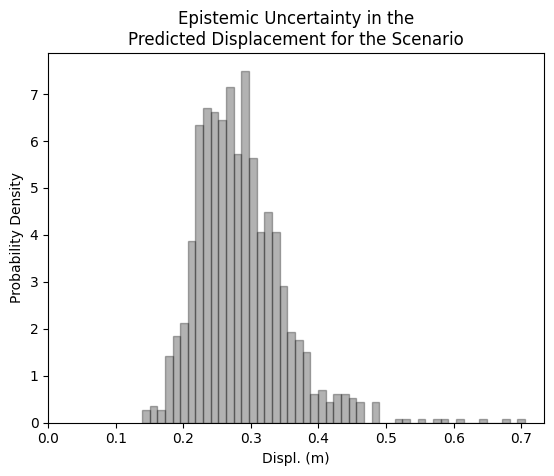

In [10]:
fig, ax = plt.subplots()
ax.hist(ans, bins=50, density=True, alpha=0.3, color="black", edgecolor="black")
ax.set(
    xlabel="Displ. (m)",
    ylabel="Probability Density",
    title="Epistemic Uncertainty in the\nPredicted Displacement for the Scenario",
    xlim=[0, None],
);

## Example 3 (show debug dataframe)

Using `debug=True` allows the user to inspect the internal calculations. This may be helpful for users who wish to verify the Box-Cox transformation that is used in the Kuehn et al. model, for example.

In [11]:
ans = kea.calc_displ_site(
    magnitude=6.5,
    location=0.25,
    style="strike-slip",
    percentile=0.5,
    coefficient_type="full",
    debug=True,
)

display(ans)

,magnitude,location,style,percentile,model_id,bc_param,mean_site,stdv_site,mean_complement,stdv_complement,Y_site,Y_complement,Y_folded,displ_site_meters,displ_complement_meters,displ_folded_meters
0,6.5,0.25,strike-slip,0.5,1,0.153139,-1.165189,1.096672,-1.438498,1.124861,-1.165189,-1.438498,-1.301844,0.277081,0.196934,0.234117
1,6.5,0.25,strike-slip,0.5,2,0.167483,-1.145499,0.804283,-1.430107,0.850953,-1.145499,-1.430107,-1.287803,0.280319,0.194988,0.234438
2,6.5,0.25,strike-slip,0.5,3,0.157091,-1.138283,0.897928,-1.421677,0.943482,-1.138283,-1.421677,-1.279980,0.285336,0.200108,0.239544
3,6.5,0.25,strike-slip,0.5,4,0.170254,-1.147103,0.873682,-1.412830,0.909474,-1.147103,-1.412830,-1.279967,0.279086,0.198672,0.236050
4,6.5,0.25,strike-slip,0.5,5,0.164652,-0.903539,0.900916,-1.203669,0.933857,-0.903539,-1.203669,-1.053604,0.375965,0.261456,0.314378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,6.5,0.25,strike-slip,0.5,996,0.166550,-1.174767,0.912672,-1.437151,0.945120,-1.174767,-1.437151,-1.305959,0.270551,0.193457,0.229316
996,6.5,0.25,strike-slip,0.5,997,0.161476,-1.001278,0.828962,-1.280092,0.874202,-1.001278,-1.280092,-1.140685,0.335490,0.238350,0.283447
997,6.5,0.25,strike-slip,0.5,998,0.160987,-1.038219,1.031860,-1.347029,1.062223,-1.038219,-1.347029,-1.192624,0.321084,0.219071,0.265998
998,6.5,0.25,strike-slip,0.5,999,0.173022,-1.176877,1.103518,-1.414521,1.131454,-1.176877,-1.414521,-1.295699,0.268223,0.197439,0.230593


# Displacement profiles

## Overview

We will use the `calc_displ_profile` function for deterministic profile calculations. A scenario is defined with:
- earthquake magnitude
- style of faulting
- percentile (i.e., aleatory quantile)

Only one scenario is permitted. In other words, the user will need to loop over the function to consider multiple cases.

Let us view the documentation `__doc__`. Note the following:
- The default location step size is 0.05, but the user may change this
- The default `coefficient_type` is `'median'` (a point estimate of the coefficients), and the `'full'` option is not available
- The default calculation is for the folded displacement profile (`folded=True`)

In [12]:
print(kea.calc_displ_profile.__doc__)


    Calculate the predicted displacement profile in meters.

    Parameters
    ----------
    magnitude : int or float or numpy.ndarray with a single element
        Earthquake moment magnitude.

    style : str
        Style of faulting (case-insensitive). Valid options are 'strike-slip', 'reverse', or
        'normal'.

    percentile : int or float or numpy.ndarray with a single element
        Aleatory quantile value. Use -1 for mean.

    coefficient_type : str, optional
        Option to run model using mean or median point estimates of the model coefficients (case-
        insensitive). Valid options are 'mean' or 'median'. (The 'full' option is not enabled for
        this function.) Default 'median'.

    folded : boolean, optional
        Return displacement for the folded location. Default True.

    location_step : float, optional
        Profile location step interval. Default 0.05.

    Returns
    -------
    tuple
        - 'locations': Normalized location along ruptu

## Example 1 (folded and unfolded profiles)

Let us compare the folded (default) and unfolded predicted displacement profiles for a scenario:

In [13]:
mag, sof, ptile = 7, "normal", 0.5

folded = kea.calc_displ_profile(magnitude=mag, style=sof, percentile=ptile)

unfolded = kea.calc_displ_profile(
    magnitude=mag, style=sof, percentile=ptile, folded=False
)

Note that function returns a tuple of location values and displacement values:

In [14]:
print(f"     Normalized locations along the rupture:\n{folded[0]}")
print(f"     Associated displacement predictions:\n{folded[1]}")

     Normalized locations along the rupture:
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
     Associated displacement predictions:
[0.19990414 0.58071301 0.74569919 0.87981681 0.99316805 1.08852471
 1.16667744 1.22772553 1.2715296  1.29790515 1.30671375 1.29790515
 1.2715296  1.22772553 1.16667744 1.08852471 0.99316805 0.87981681
 0.74569919 0.58071301 0.19990414]


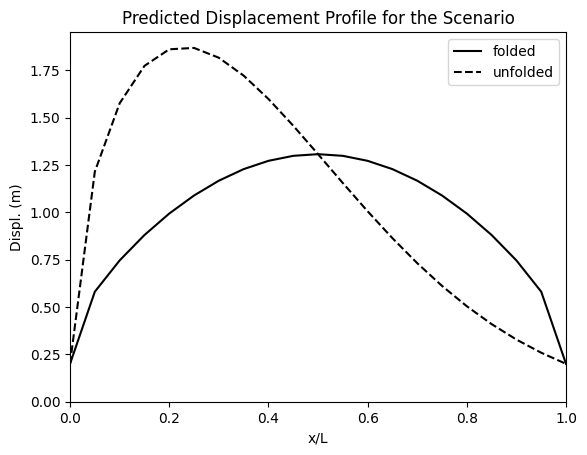

In [15]:
fig, ax = plt.subplots()
ax.plot(folded[0], folded[1], color="black", linestyle="solid", label="folded")
ax.plot(unfolded[0], unfolded[1], color="black", linestyle="dashed", label="unfolded")
ax.set(
    xlim=[0, 1],
    ylim=[0, None],
    xlabel="x/L",
    ylabel="Displ. (m)",
    title="Predicted Displacement Profile for the Scenario",
)
ax.legend(loc="upper right");

In [16]:
# Clean
del ans, mag, sof, ptile, folded, unfolded, fig, ax

## Example 2 (compare percentiles)

Let us compare the predicted profiles for different percentiles. Note that we can use `percentile=-1` for the mean.

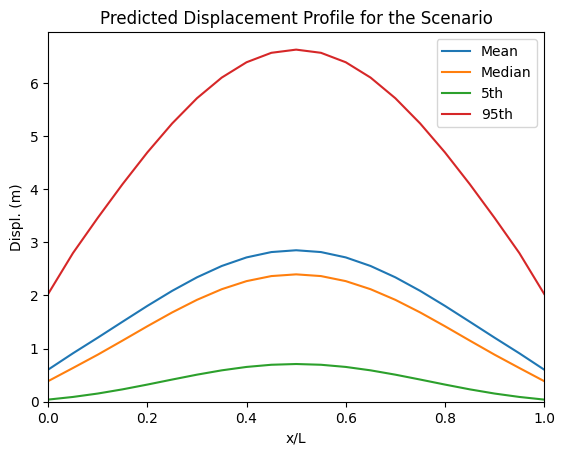

In [17]:
mag, sof = 7.2, "strike-slip"

pred_mean = kea.calc_displ_profile(magnitude=mag, style=sof, percentile=-1)
pred_median = kea.calc_displ_profile(magnitude=mag, style=sof, percentile=0.5)
pred_q5 = kea.calc_displ_profile(magnitude=mag, style=sof, percentile=0.05)
pred_q95 = kea.calc_displ_profile(magnitude=mag, style=sof, percentile=0.95)

fig, ax = plt.subplots()
for results, label in zip(
    [pred_mean, pred_median, pred_q5, pred_q95], ["Mean", "Median", "5th", "95th"]
):
    ax.plot(results[0], results[1], label=label)

ax.set(
    xlim=[0, 1],
    ylim=[0, None],
    xlabel="x/L",
    ylabel="Displ. (m)",
    title="Predicted Displacement Profile for the Scenario",
)
ax.legend(loc="upper right");

In [18]:
# Clean
del pred_mean, pred_median, pred_q5, pred_q95, mag, sof, fig, ax, results, label

# Average displacement

We will use the `calc_displ_avg` function to calculate the median prediction for the average displacement given magnitude and style of faulting. Only one scenario is permitted, so, the user will need to loop over the function to consider multiple cases.

Let us view the documentation `__doc__`:

In [19]:
print(kea.calc_displ_avg.__doc__)


    Calculate the median predicted average displacement in meters.

    Parameters
    ----------
    magnitude : int or float or numpy.ndarray with a single element
        Earthquake moment magnitude.

    style : str
        Style of faulting (case-insensitive). Valid options are 'strike-slip', 'reverse', or
        'normal'.

    coefficient_type : str, optional
        Option to run model using mean or median point estimates of the model coefficients (case-
        insensitive). Valid options are 'mean' or 'median'. (The 'full' option is not enabled for
        this function.) Default 'median'.

    Returns
    -------
    float
        Average displacement in meters.

    Raises
    ------
    ValueError
        If `coefficient_type` is not 'mean' or 'median'.

    Examples
    --------
    From command line:

    .. code-block:: console

        $ kea-displ_avg -m 7 -s normal
    


## Example (magnitude scaling)

In [20]:
%%capture output
# Capture numpy depreciation warnings; the code uses `np.trapz()` instead of `np.trapezoid()` ...
# ... to maintain backwards compatibility with numpy 1.x

# Define magnitude array
mags = np.arange(6,8.1,.1)

ad_ss = np.array([kea.calc_displ_avg(magnitude=m, style="strike-slip") for m in mags])
ad_rv = np.array([kea.calc_displ_avg(magnitude=m, style="reverse") for m in mags])
ad_nm = np.array([kea.calc_displ_avg(magnitude=m, style="normal") for m in mags])

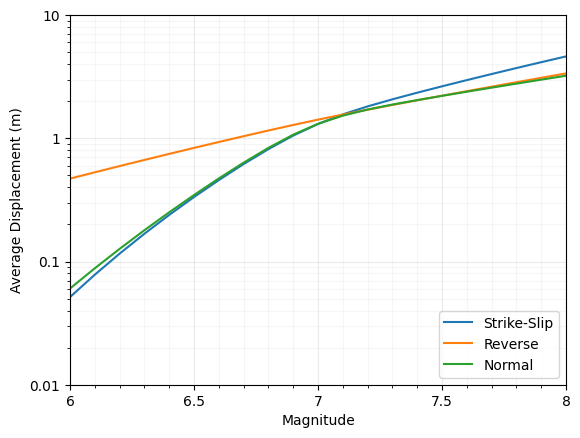

In [21]:
fig, ax = plt.subplots()
ax.semilogy(mags, ad_ss, label="Strike-Slip")
ax.semilogy(mags, ad_rv, label="Reverse")
ax.semilogy(mags, ad_nm, label="Normal")

ax.set(
    xlim=[min(mags), max(mags)],
    ylim=[0.01, 10],
    xlabel="Magnitude",
    ylabel="Average Displacement (m)",
)
ax.legend(loc="lower right")

ax.set_xticks(np.arange(min(mags), max(mags) + 0.5, 0.5))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
plt.minorticks_on()
ax.grid(which="major", axis="both", alpha=0.25)
ax.grid(which="minor", axis="both", alpha=0.1)

In [22]:
# Clean
del ad_ss, ad_rv, ad_nm, mags, fig, ax

# Probability of exceedance

## Overview

We will use the `calc_prob_exceed` function for probability of exceedance calculations. A scenario is defined with:
- earthquake magnitude
- normalized location along the rupture length
- style of faulting

Only one scenario is permitted.

Let us view the documentation `__doc__`. Note the following:
- The user must specify the displacement test values, which may be `int`, `float`, `list`, or `np.ndarray` type
- The default `coefficient_type` is `'median'` (a point estimate of the coefficients)
- The default calculation is for the folded displacement profile (`folded=True`)

The `debug` option will be demonstrated below.

In [23]:
print(kea.calc_prob_exceed.__doc__)


    Calculate the probability of exceedance.

    Parameters
    ----------
    magnitude : int or float or numpy.ndarray with a single element
        Earthquake moment magnitude.

    location : int or float or numpy.ndarray with a single element
        Normalized location along rupture length, range [0, 1.0].

    style : str
        Style of faulting (case-insensitive). Valid options are 'strike-slip', 'reverse', or
        'normal'.

    displacement_array : ArrayLike
        Test values of displacement in meters.

    coefficient_type : str, optional
        Option to run model using full epistemic uncertainty or with point estimates (mean or
        median) of the model coefficients (case-insensitive). Valid options are 'mean', 'median',
        or 'full'. Default 'median'.

    folded : boolean, optional
        Return probability of exceedance for the folded location. Default True.

    debug : boolean, optional
        Option to return DataFrame of internal calculations. De

## Example 1 (median coefficients)

We will only specify the required arguments, using the defaults for the optional arguments. An array of exceedance probabilities is returned.

In [24]:
# Displacement values, evenly spaced in log-space
displ = np.logspace(start=np.log(0.01), stop=np.log(50), num=20, base=np.e)

ans = kea.calc_prob_exceed(
    magnitude=7, location=0.2, style="reverse", displacement_array=displ
)
print(
    f"     The exceedance probabilities for the displacements in this scenario are:\n {ans}"
)

     The exceedance probabilities for the displacements in this scenario are:
 [9.99943260e-01 9.99829341e-01 9.99499084e-01 9.98577920e-01
 9.96131471e-01 9.90010895e-01 9.75742525e-01 9.45101595e-01
 8.85316030e-01 7.81375511e-01 6.25028321e-01 4.29870333e-01
 2.38146862e-01 9.86378582e-02 2.81853712e-02 5.11103340e-03
 5.40597506e-04 3.07504730e-05 8.77050791e-07 1.19574513e-08]


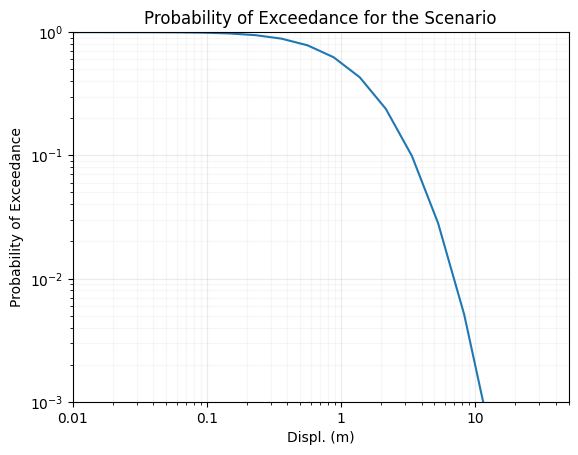

In [25]:
fig, ax = plt.subplots()
ax.loglog(displ, ans)
ax.set(
    xlim=[min(displ), max(displ)],
    ylim=[1e-3, 1],
    xlabel="Displ. (m)",
    ylabel="Probability of Exceedance",
    title="Probability of Exceedance for the Scenario",
)

ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
plt.minorticks_on()
ax.grid(which="major", axis="both", alpha=0.25)
ax.grid(which="minor", axis="both", alpha=0.1)

As with the other functions, invalid location values will raise an error and magnitudes outside the recommended range will raise a warning:

In [26]:
try:
    ans = kea.calc_prob_exceed(
        magnitude=7, location=10, style="reverse", displacement_array=displ
    )
except ValueError as e:
    print(e)

One or more location values are not within the range [0, 1].


In [27]:
ans = kea.calc_prob_exceed(
    magnitude=8.5, location=0.2, style="reverse", displacement_array=displ
)
print(
    f"     The exceedance probabilities for the displacements in this scenario are:\n {ans}"
)

     The exceedance probabilities for the displacements in this scenario are:
 [9.99999962e-01 9.99999824e-01 9.99999188e-01 9.99996310e-01
 9.99983652e-01 9.99930244e-01 9.99717169e-01 9.98925920e-01
 9.96235425e-01 9.87993730e-01 9.65605115e-01 9.12560077e-01
 8.05413609e-01 6.27667386e-01 3.99060878e-01 1.87640579e-01
 5.84972830e-02 1.07970706e-02 1.05453361e-03 4.90101996e-05]


D:\Documents\_mydocs\Work FDHI\TEAM\Journal\GITHUB\kuehn_et_al_fdm\src\kuehn_et_al_fdm\utilities.py:48: UserWarning: 
***One or more magnitudes are not within the recommended range for reverse faulting, which is [5, 8].
  warnings.warn(warning_message, UserWarning)


In [28]:
# Clean
del ans, fig, ax, displ

## Example 2 (full coefficients)

Let us look at the results using the full coefficients. A Pandas DataFrame is returned, with 1000 rows for each displacement test value.

In [29]:
# Displacement values, evenly spaced in log-space
displ = np.logspace(start=np.log(0.01), stop=np.log(50), num=20, base=np.e)

ans_full_coeffs = kea.calc_prob_exceed(
    magnitude=6.8,
    location=0.33,
    style="strike-slip",
    displacement_array=displ,
    coefficient_type="full",
)

display(ans_full_coeffs)

,model_id,displ_meters,probex_folded
0,1,0.01,0.999168
0,1,0.015656,0.998198
0,1,0.024511,0.996101
0,1,0.038375,0.991634
0,1,0.06008,0.98236
...,...,...,...
999,1000,8.322225,0.000455
999,1000,13.029331,0.000021
999,1000,20.398806,0.0
999,1000,31.936504,0.0


Let us plot all the probability of exceedance curves to see the within-model epistemic uncertainty:

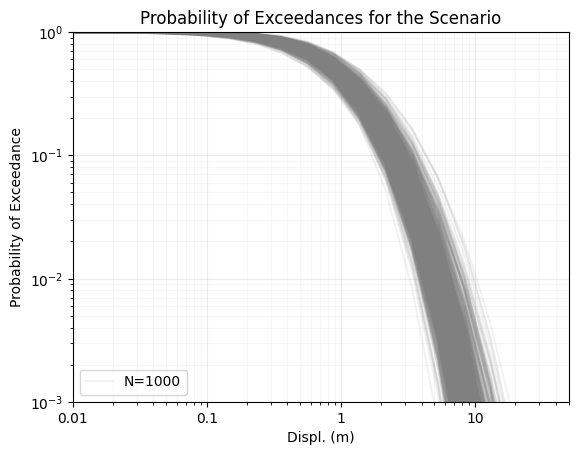

In [30]:
fig, ax = plt.subplots()

# Plot all lines
x, y = "displ_meters", "probex_folded"
for _coeff, _group in ans_full_coeffs.groupby("model_id"):
    _group = _group.sort_values(by=x)
    ax.loglog(_group[x], _group[y], c="gray", alpha=0.1)

# Create ghost line for legend
n = max(ans_full_coeffs["model_id"])
ax.loglog([-1, -1], [-1, -1], c="gray", alpha=0.1, label=f"N={n}")

# Plot formatting
ax.set(
    xlim=[min(displ), max(displ)],
    ylim=[1e-3, 1],
    xlabel="Displ. (m)",
    ylabel="Probability of Exceedance",
    title="Probability of Exceedances for the Scenario",
)

ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
plt.minorticks_on()
ax.grid(which="major", axis="both", alpha=0.25)
ax.grid(which="minor", axis="both", alpha=0.1)
ax.legend(loc="lower left");

### Epistemic fractiles

Let us now quantify the epistemic uncertainty by computing the epistemic fractiles. We will use [StatsModels](https://www.statsmodels.org/stable/index.html) here for convenience. The `DescrStatsW` class provides an instance with descriptive statistics with methods such as `quantile` and `mean`.

In [31]:
from statsmodels.stats.weightstats import DescrStatsW

We will create a function to calculate the fractiles (and the mean) based on the DataFrame output from `calc_prob_exceed`. We will then use the `apply` method in Pandas to apply the function to each group (i.e., displacement value) in the DataFrame. 

(Alternatively, inline chaining with a lambda function could be used instead of defining our own function.)

In [32]:
def calc_stats(dataframe, column, fractiles):
    """
    Calculate quantiles and mean for the specified column in the DataFrame.

    Parameters:
        dataframe (pd.DataFrame): Data containing the column for analysis.
        rate_column (str): Column name to calculate statistics for.
        fractiles (list or ArrayLike): Quantiles of interest.

    Returns:
        pd.Series: Series containing the mean and quantiles.
    """

    stats = DescrStatsW(dataframe[column])
    info = stats.quantile(fractiles)
    info["Mean"] = stats.mean

    return info

In [33]:
# Define epistemic fractiles of interest
ptiles = [0.05, 0.5, 0.95]

# Compute discriptive statistics object
statistics = (
    ans_full_coeffs.groupby(["displ_meters"])
    .apply(
        calc_stats,
        column="probex_folded",
        fractiles=ptiles,
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# Display the results
statistics.head()

C:\Users\starb\AppData\Local\Temp\ipykernel_22216\72014063.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ans_full_coeffs.groupby(["displ_meters"])


,displ_meters,0.05,0.5,0.95,Mean
0,0.010000,0.999096,0.999869,0.999982,0.999737
1,0.015656,0.998123,0.999662,0.999941,0.999408
2,0.024511,0.995925,0.999115,0.999805,0.998640
3,0.038375,0.991441,0.997687,0.999370,0.996830
4,0.060080,0.982163,0.994001,0.997982,0.992584


Let us improve our previous plot by adding the exceedance probabilities for the fractiles and mean to quantify the epistemic uncertainty:

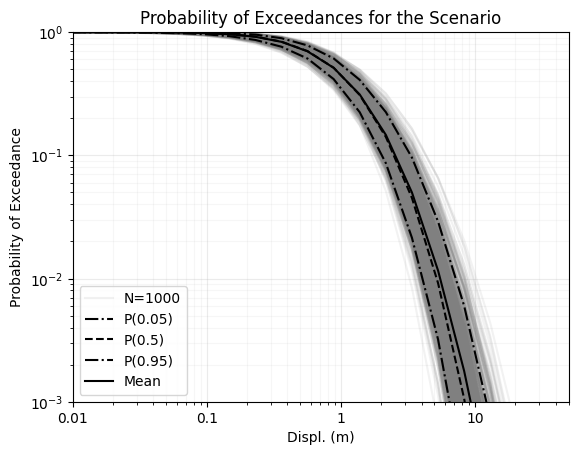

In [34]:
fig, ax = plt.subplots()

# Plot all lines
x, y = "displ_meters", "probex_folded"
for _coeff, _group in ans_full_coeffs.groupby("model_id"):
    _group = _group.sort_values(by=x)
    ax.loglog(_group[x], _group[y], c="gray", alpha=0.1)

# Create ghost line for legend
n = max(ans_full_coeffs["model_id"])
ax.loglog([-1, -1], [-1, -1], c="gray", alpha=0.1, label=f"N={n}")

# Plot fractiles and mean
names = [0.05, 0.5, 0.95, "Mean"]
labels = ["P(0.05)", "P(0.5)", "P(0.95)", "Mean"]
linestyles = ["dashdot", "dashed", "dashdot", "solid"]
for _name, _ls, _label in zip(names, linestyles, labels):
    ax.loglog(
        statistics["displ_meters"],
        statistics[_name],
        color="black",
        linestyle=_ls,
        label=_label,
    )

# Plot formatting
ax.set(
    xlim=[min(displ), max(displ)],
    ylim=[1e-3, 1],
    xlabel="Displ. (m)",
    ylabel="Probability of Exceedance",
    title="Probability of Exceedances for the Scenario",
)

ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
plt.minorticks_on()
ax.grid(which="major", axis="both", alpha=0.25)
ax.grid(which="minor", axis="both", alpha=0.1)
ax.legend(loc="lower left");

### Mean with and without epistemic uncertainty

And finally, let us compare the mean probability of exceedances with and without model epistemic uncertainty:

In [35]:
# Compute probability of exceedance for the same scenario using the median coefficients (default)
ans_median_coeffs = kea.calc_prob_exceed(
    magnitude=6.8,
    location=0.33,
    style="strike-slip",
    displacement_array=displ,
)

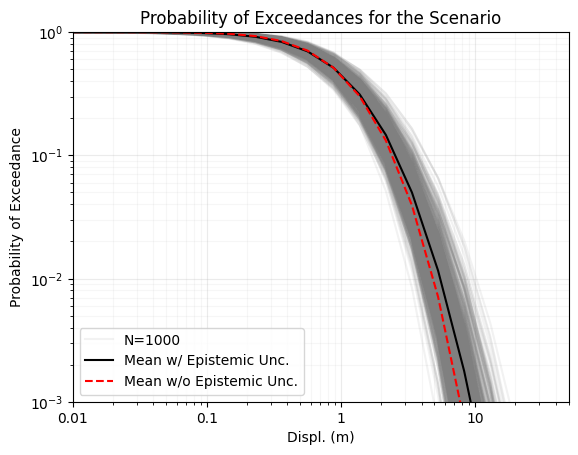

In [36]:
fig, ax = plt.subplots()


# Plot all lines
x, y = "displ_meters", "probex_folded"
for _coeff, _group in ans_full_coeffs.groupby("model_id"):
    _group = _group.sort_values(by=x)
    ax.loglog(_group[x], _group[y], c="gray", alpha=0.1)

# Create ghost line for legend
n = max(ans_full_coeffs["model_id"])
ax.loglog([-1, -1], [-1, -1], c="gray", alpha=0.1, label=f"N={n}")

# Plot mean with epistemic uncertainty
ax.loglog(
    statistics["displ_meters"],
    statistics["Mean"],
    color="black",
    linestyle="solid",
    label="Mean w/ Epistemic Unc.",
)

# Plot mean without epistemic uncertainty
ax.loglog(
    displ,
    ans_median_coeffs,
    color="red",
    linestyle="dashed",
    label="Mean w/o Epistemic Unc.",
)

# Plot formatting
ax.set(
    xlim=[min(displ), max(displ)],
    ylim=[1e-3, 1],
    xlabel="Displ. (m)",
    ylabel="Probability of Exceedance",
    title="Probability of Exceedances for the Scenario",
)

ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
plt.minorticks_on()
ax.grid(which="major", axis="both", alpha=0.25)
ax.grid(which="minor", axis="both", alpha=0.1)
ax.legend(loc="lower left");

## Example 3 (show debug dataframe)

Using `debug=True` allows the user to inspect the internal calculations.

In [37]:
displ = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 50]

ans = kea.calc_prob_exceed(
    magnitude=7, location=0.2, style="reverse", displacement_array=displ, debug=True
)

ans.head()

,magnitude,location,style,model_id,bc_param,mean_site,stdv_site,mean_complement,stdv_complement,displ_meters,transformed_displ,probex_site,probex_complement,probex_folded
0,7,0.2,reverse,median,0.11772,0.450992,0.802477,-0.14973,0.923415,0.01,-3.554933,1.0,0.999887,0.999943
0,7,0.2,reverse,median,0.11772,0.450992,0.802477,-0.14973,0.923415,0.03,-2.872922,0.999983,0.998406,0.999195
0,7,0.2,reverse,median,0.11772,0.450992,0.802477,-0.14973,0.923415,0.1,-2.016901,0.998949,0.978413,0.988681
0,7,0.2,reverse,median,0.11772,0.450992,0.802477,-0.14973,0.923415,0.3,-1.122545,0.975052,0.853943,0.914498
0,7,0.2,reverse,median,0.11772,0.450992,0.802477,-0.14973,0.923415,1.0,0.0,0.712942,0.435594,0.574268


In [38]:
# Clean
del (
    ans,
    ans_full_coeffs,
    ans_median_coeffs,
    statistics,
    displ,
    ptiles,
    labels,
    linestyles,
    names,
    x,
    y,
    fig,
    ax,
    n,
)

# Percentile rank analysis

Users may wish to calculate the percentile ranks (i.e., aleatory quantiles) for a dataset of observations.

We will use the `calc_prob_occur` function for probability of exceedance calculations. A scenario is defined with:
- earthquake magnitude
- style of faulting

Let us view the documentation `__doc__`. Note the following:
- The user must specify the displacement observations and corresponding (normalized) locations
- The data should be oriented such that the largest displacement is left of the midpoint

In [39]:
print(kea.calc_prob_occur.__doc__)


    Calculate the percentile rank of observations.
    Note that the ocation-displacement array pairs should be oriented with the profile peak at
    location <= 0.5.

    Parameters
    ----------
    magnitude : int or float or numpy.ndarray with a single element
        Earthquake moment magnitude.

    location_array : ArrayLike
        Normalized locations along rupture length, range [0, 1.0].

    style : str
        Style of faulting (case-insensitive). Valid options are 'strike-slip', 'reverse', or
        'normal'.

    displacement_array : ArrayLike
        Test values of displacement in meters.

    coefficient_type : str, optional
        Option to run model using mean or median point estimates of the model coefficients (case-
        insensitive). Valid options are 'mean' or 'median'. (The 'full' option is not enabled for
        this function.) Default 'median'.

    Returns
    -------
    percentile : numpy.ndarray
        Percentile rank for the location-displacement 

## Example

Let us use observations from the 1939 **M** 7.7 Erzincan, Turkey strike-slip earthquake provided in Wesnousky (2008; https://doi.org/10.1785/0120070111).

We will assume that the observations are compatible with the Kuehn et al. model (i.e., that they are aggregate net displacement) for the purposes of this example.

In [40]:
distance_km = np.asarray(
    [
        0,
        28.464,
        42.758,
        82.773,
        108.3,
        128.55,
        146.03,
        169.95,
        171.2,
        174.71,
        184,
        205.08,
        215.98,
        219.18,
        223.55,
        232.76,
        235.29,
        242.66,
        246.85,
        253.2,
        255.25,
        274.18,
        281.62,
        286.95,
        297.15,
        300,
    ]
)

slip_m = np.asarray(
    [
        0,
        1.7576,
        2.1542,
        3.3309,
        3.9393,
        4.3362,
        4.0202,
        5.1037,
        5.5922,
        7.3746,
        5.606,
        6.465,
        5.845,
        5.0663,
        7.0071,
        7.4431,
        6.704,
        6.097,
        6.0972,
        6.4935,
        5.992,
        6.4416,
        2.0855,
        5.0693,
        1.5186,
        0,
    ]
)

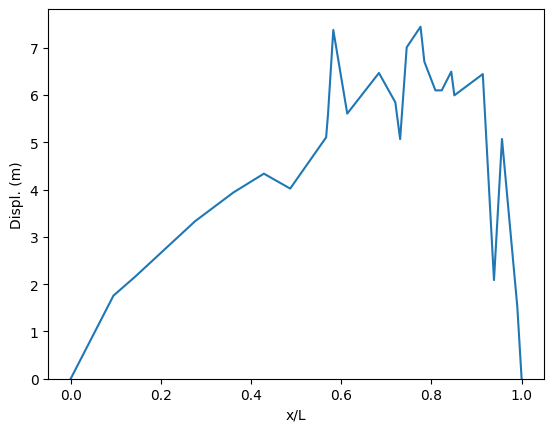

In [41]:
# Normalize locations
location = distance_km / max(distance_km)

# Plot to check if peak displ is left of center
fig, ax = plt.subplots()
ax.plot(location, slip_m)
ax.set(ylim=[0, None], xlabel="x/L", ylabel="Displ. (m)");

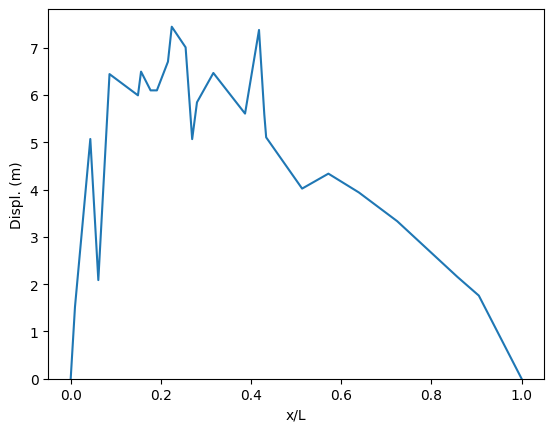

In [42]:
# Flip the data so that peak displ is left of center
location = 1 - location

fig, ax = plt.subplots()
ax.plot(location, slip_m)
ax.set(ylim=[0, None], xlabel="x/L", ylabel="Displ. (m)");

The Kuehn et al. model provides displacement probabilities for *non-zero* displacements; therefore, we will remove any zeros:

In [43]:
nonzero_mask = slip_m != 0
slip_m_nonzero = slip_m[nonzero_mask]
location_nonzero = location[nonzero_mask]

In [44]:
# Calculate percentile rank
ans = kea.calc_prob_occur(
    magnitude=7.7,
    style="strike-slip",
    location_array=location_nonzero,
    displacement_array=slip_m_nonzero,
)

[(0.0, 1.0),
 (0.0, 8.0),
 Text(0.5, 0, 'x/L'),
 Text(0, 0.5, 'Observed\nDispl. (m)')]

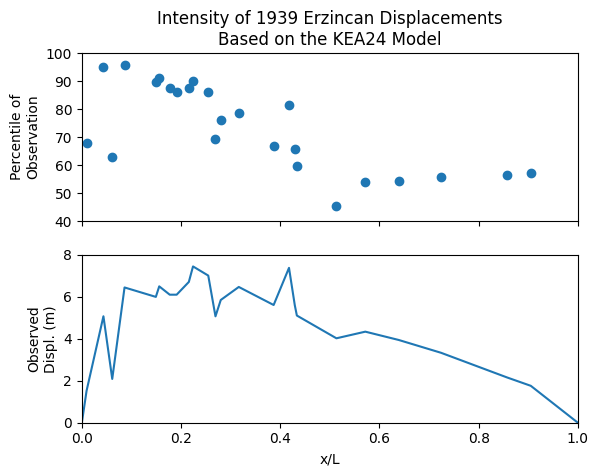

In [45]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].scatter(location_nonzero, ans * 100)
ax[1].plot(location, slip_m)

ax[0].set(
    ylim=[40, 100],
    ylabel="Percentile of\nObservation",
    title="Intensity of 1939 Erzincan Displacements\nBased on the KEA24 Model",
)

ax[1].set(
    xlim=[0, 1],
    ylim=[0, 8],
    xlabel="x/L",
    ylabel="Observed\nDispl. (m)",
);

In [46]:
# Clean
del (
    ans,
    distance_km,
    slip_m,
    location,
    location_nonzero,
    slip_m_nonzero,
    nonzero_mask,
    fig,
    ax,
)

# End of Notebook